# Third task

* Download the SPT fgas data
* Fit the data to f0(1 + f1z) where f0 and f1 are unknown constants
* Determine the best fit values of f0 and f1 including 68% and 90% credible intervals using emcee and corner.py
* The priors on f0 and f1 should be 0<f0 <0.5 and −0.5<f1 <0.5.
* Use the same likelihood as in equation 6 of   https://arxiv.org/pdf/2001.08340.pdf (radial acceleration relation for galaxy cluster
* download emcee and python corner module and look up https://emcee.readthedocs.io/en/stable/tutorials/line/ which shows how to fit a model to a straight line


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as spy

In [2]:
fname = np.loadtxt('fgas_spt.txt', delimiter= " ") #loading the given data
print('the structure is z, fgas, fgas_error, ignore', fname[0]) #checking for the structre of the element

the structure is z, fgas, fgas_error, ignore [0.2777     0.09661017 0.01488267 0.        ]


In [3]:
# arrays as given in the data

z = [] #red shift
fgas = [] #hot gas fraction
fgas_err = [] #corresponding error in the observations
ignore = []

for i in fname:
    z.append(i[0])
    fgas.append(i[1])
    fgas_err.append(i[2])
    ignore.append(i[3])
    
x = np.array(z)
y = np.array(fgas)
yerr = np.array(fgas_err)

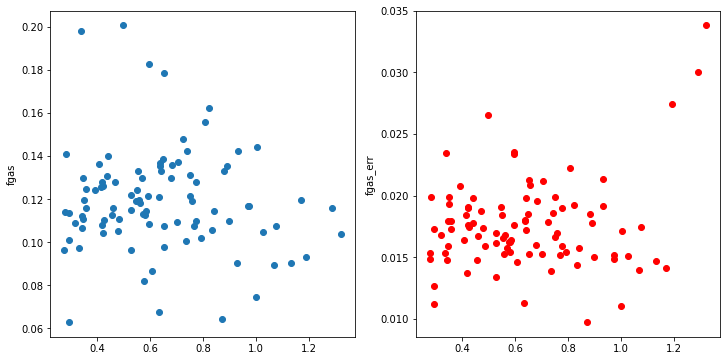

In [4]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].scatter(x , y)
ax[1].scatter(x,yerr, color='r')
ax[0].set_ylabel('fgas')
ax[1].set_ylabel('fgas_err')

plt.show()

* as per the scatter plot of fgas and fgas_err with z; we have a range from 0.100 to 0.150 in fgas with z without much deviation
* for the error values, the observed range is from 0.015 to 0.020 with few points lying outside the range

## likelyhood function to be used
* the function used is a log-likelyhood function given as
$$ ln \mathcal{ \ L} = -1/2 \sum_i \left( ln(2\pi \sigma_i^{2}) + \frac{[y_i - (mx_i + b)]^2}{\sigma_i^2}\right)$$
* where i runs over all the clusters and data points and $\sigma_i$ includes the observational uncertanitites $\sigma_{x_i}, \sigma_{y_i}$ and lognormal intrinsic scatter $\sigma_{int}$
* $\sigma_i^2 = \sigma_{y_i}^2 + m^2\sigma_{x_i}^2 + \sigma_{int}^2$
* $\sigma_{int}$ accounts for the intrinsic scatter around the mean RAR (radial acceleration relation) due to unaccounted astrophysics associated with the RAR

In [5]:
#coding the likelyhood function
def log_likelihood(theta, x, y, yerr):
    m = theta[0]
    b = theta[1]
    log_f = theta[2]

    model = m*x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f) 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))

* as per the standard equation and the given model $f0*(1 + f1*z)$; we have $m = f0*f1$ and $ b = f0 \implies f0 = b \ \& \ f1 = \frac{m}{f0}$  with $$ 0< b <0.5 \ and -0.25< m < 0.25$$

Maximum likelihood estimates:
m = -0.008
b = 0.121
f = 0.137 

the best fit values from maximum likelihood is
f0 = 0.121
f1 = -0.069


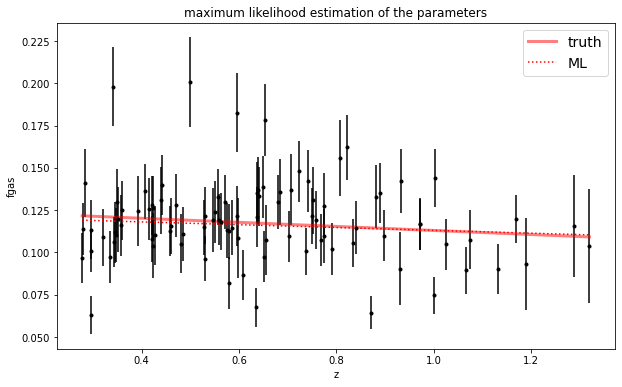

In [7]:
from scipy.optimize import minimize

# choosing the true parameters
m_true = -0.012
b_true = 0.125
f_true = np.std(ignore) #fractional amount of underestimation

nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) #making array of true params
soln = minimize(nll, initial, args=(x, y, yerr))#minimized the -ve likelihood function
m_ml, b_ml, log_f_ml = soln.x #output of the values

f0 = b_ml
f1 = m_ml/b_ml

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f} \n".format(np.exp(log_f_ml)))

print('the best fit values from maximum likelihood is')
print("f0 = {0:.3f}".format(b_ml))
print("f1 = {0:.3f}".format(m_ml/b_ml))

plt.figure(figsize=(10,6))
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, m_true * x + b_true, "r", alpha=0.5, lw=3, label="truth") #true linear plot
#plt.plot(x, np.dot(np.vander(x, 2), w), "--k", label="LS") 
plt.plot(x, np.dot(np.vander(x, 2), [m_ml, b_ml]), ":r", label="ML") #maximum likelihood function estimation
plt.legend(fontsize=14)

#plt.xlim(0, 10)
plt.xlabel("z")
plt.ylabel('fgas')
plt.title('maximum likelihood estimation of the parameters')
plt.show()

### using corner and emcree to make mcmc

In [75]:
import corner
#fig = corner.corner(y, quantiles=(0.16, 0.84), levels=(0.68,)) #68% of the interval
#_ = fig.suptitle("68% interval of the fgas")

In [76]:
# fig = corner.corner(y, quantiles=(0.06, 0.96), levels=(0.90,)) #68% of the interval
# _ = fig.suptitle("90% interval of the fgas")

In [77]:
#making a prior function
def log_prior(theta):
    m, b, log_f = theta
    if -0.25< m < 0.25 and 0.0 < b < 0.5 and -5.0< log_f < 1.0:
        return 0.02 #not sure what is this
    return -np.inf


In [78]:
#log_probability function
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [79]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);


100%|██████████████████████████████████████| 5000/5000 [00:06<00:00, 716.61it/s]


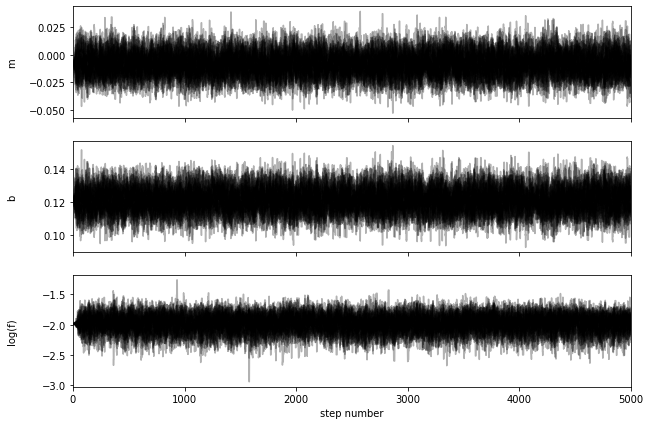

In [80]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [81]:
tau = sampler.get_autocorr_time()
print(tau)

[36.5985108  36.32789534 34.05449859]


In [82]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


### generating corner plots

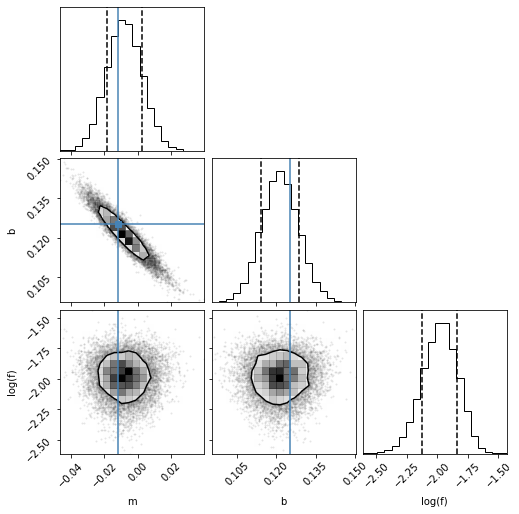

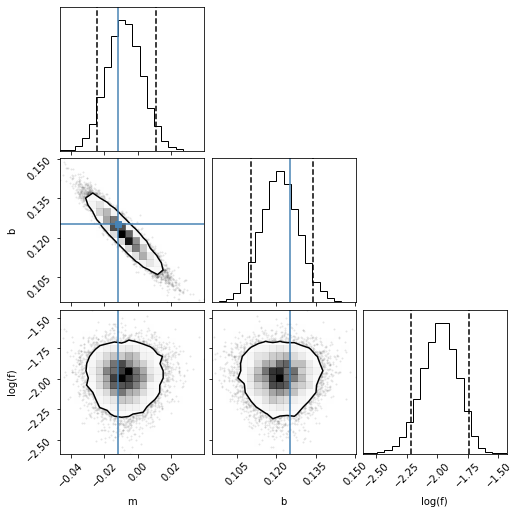

In [90]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)], levels=(0.68,), quantiles=(0.16, 0.84)
);

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)], levels=(0.90,), quantiles=(0.06, 0.96)
);


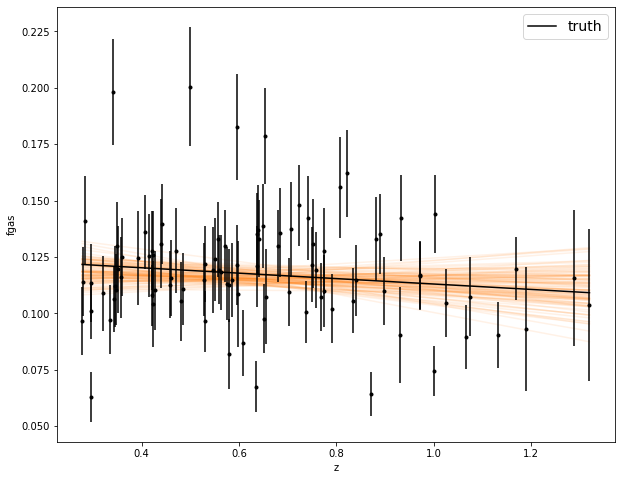

In [91]:
plt.figure(figsize=(10,8))
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x, np.dot(np.vander(x, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, m_true * x + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlabel("z")
plt.ylabel("fgas");

In [92]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [6, 50, 90])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    txt1 = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [93]:
print("f0 = {0:.3f}".format(-0.008))
print("f1 = {0:.3f}".format(-0.008/0.121))

f0 = -0.008
f1 = -0.066


* the best fit values are same as the ones from maximum likelihood function